In [7]:
#import relevant libraries
import os
from scipy import stats

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
import dabest
import NLCLIMB
import NLMATH
import itertools
from datetime import datetime
date = datetime.today().strftime('%Y%m%d')
from statistics import mean
from textwrap import wrap

import dabest
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objects import Layout
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#NOTE: SUPPRESSES WARNINGS!

import warnings


warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

print("dabest", dabest.__version__)
print("numpy", np.version.version)
print("seaborn", sns.__version__)

dabest 2024.03.30
numpy 1.26.4
seaborn 0.13.2


In [8]:
#initial file processing
workcomp = "C:\\Users\\User"
computer2 = "C:\\Users\\lnico"
officecomp = "C:\\Users\\Star"
homecomp = "D:"
filedir = "\\ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Data Compilation\\Falling_New\\"
titledpath = homecomp
openPath = titledpath + filedir
files = os.listdir(openPath)

#identifying genotypes
responder = "ACR"
respondercsv = responder + ".csv"
wt = "w1118"


In [9]:
lstnew=[]


for file_no in os.listdir(openPath): 
    if respondercsv in file_no and "w1118" not in file_no :   #wt > acr files
        f = os.path.join(openPath, file_no)
        dfe=pd.read_csv(f)
        exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
        driver = file_no.split(" ")[0]
        lstnew.append(driver)

In [10]:
dflists = ['df_bspeed', 'df_speed', 'df_time', 'df_fall','df_height', 'df_displacement', 'df_meanpause', 'df_pause','df_meanbout', 'df_bout','df_boutpos', 'df_pausepos','df_maxvelocity','df_straightindex', 'df_displacementbetweenpause', "df_ascent", "df_descent"]
    
dflists2 = [s.replace('df_', 'dfreg_') for s in dflists]

In [19]:
def new_deltav(df_sp, metric):
    
    df6 = df_sp[(df_sp['ExperimentState'] != "Recovery") ]
    name = []
    if any(df6[metric].isnull()):
        name = df6[df6[metric].isnull()]['index'].tolist()
    dfsp_db = df6[~df6['index'].isin(name)]
           
    dfsp_db2 = dabest.load(data = dfsp_db, x = ["ExperimentState", "Type"], y = metric,  delta2 = True, experiment = "Type",
                            experiment_label = ['WT', 'Expt'], x1_level = ["Dark", "Full"], paired = "baseline", id_col="index" ) #if delta2 = dabest; deltaG = dabest_jck
    plot_data = dfsp_db2._plot_data
    idx = dfsp_db2.idx
    xvar = dfsp_db2._xvar
    yvar = dfsp_db2._yvar
    is_paired = dfsp_db2.is_paired
    id_col = dfsp_db2.id_col

    delta_plot_data_temp = plot_data.copy()
    delta_id_col = id_col
    delta_plot_data = delta_plot_data_temp[[xvar, yvar, delta_id_col]]

    final_deltas = pd.DataFrame()
    for i in idx:
        for j in i:
            if i.index(j) != 0:
                temp_df_exp = delta_plot_data[
                    delta_plot_data[xvar].str.contains(j)
                ].reset_index(drop=True)
                if is_paired == "baseline":
                    temp_df_cont = delta_plot_data[
                        delta_plot_data[xvar].str.contains(i[0])
                    ].reset_index(drop=True)
                elif is_paired == "sequential":
                    temp_df_cont = delta_plot_data[
                        delta_plot_data[xvar].str.contains(
                            i[i.index(j) - 1]
                        )
                    ].reset_index(drop=True)
                delta_df = temp_df_exp.copy()
                delta_df[yvar] = temp_df_exp[yvar] - temp_df_cont[yvar]
                final_deltas = pd.concat([final_deltas, delta_df])
    
    return final_deltas

In [20]:
def testingforPCA(n, df_sp, df_bsp, df_f, df_h, df_dispp, df_maxv, df_sim, alltgtmeandf_bout, alltgtnumberdf_bout, count):
    totaldf = pd.DataFrame()
       
    totaldf["Bout speed"] = new_deltav(df_bsp, "BSpeed")[new_deltav(df_bsp, "BSpeed")['TypeExperimentState']=="Full Expt"]['BSpeed'].reset_index(drop=True)
    totaldf["Speed"] = new_deltav(df_sp, "Velocity")[new_deltav(df_sp, "Velocity")['TypeExperimentState']=="Full Expt"]['Velocity'].reset_index(drop=True)
    totaldf["Fall #"] = new_deltav(df_f, "Fall")[new_deltav(df_f, "Fall")['TypeExperimentState']=="Full Expt"]['Fall'].reset_index(drop=True)
    totaldf["Height"] = new_deltav(df_h, "Y")[new_deltav(df_h, "Y")['TypeExperimentState']=="Full Expt"]['Y'].reset_index(drop=True)
    totaldf["Mean Bout"] = new_deltav(alltgtmeandf_bout, "Bouts")[new_deltav(alltgtmeandf_bout, "Bouts")['TypeExperimentState']=="Full Expt"]['Bouts'].reset_index(drop=True)
    totaldf["Bout #"] = new_deltav(alltgtnumberdf_bout, "Bouts")[new_deltav(alltgtnumberdf_bout, "Bouts")['TypeExperimentState']=="Full Expt"]['Bouts'].reset_index(drop=True)    
    totaldf["Max velocity"] = new_deltav(df_maxv, "maxvelocity")[new_deltav(df_maxv, "maxvelocity")['TypeExperimentState']=="Full Expt"]['maxvelocity'].reset_index(drop=True)
    totaldf["Avg Straightness index"] = new_deltav(df_sim, "averagestraightnessindex")[new_deltav(df_sim, "averagestraightnessindex")['TypeExperimentState']=="Full Expt"]['averagestraightnessindex'].reset_index(drop=True)
    totaldf["displacement between pause"] = new_deltav(df_dispp, "avgdisplacementbetweenpause")[new_deltav(df_dispp, "avgdisplacementbetweenpause")['TypeExperimentState']=="Full Expt"]['avgdisplacementbetweenpause'].reset_index(drop=True)
    totaldf['MBON'] = n
    totaldf = totaldf.set_index(['MBON'])
    totaldf['number'] = count

    return totaldf
    
    

In [21]:
totaldf = pd.DataFrame()
count = 0
for n in lst:
    count +=1
    transgenic = n + " x " + responder
    filename = openPath + transgenic + ".csv"
    filenamewt = openPath + wt+"_"+ transgenic + ".csv"

    dfe=pd.read_csv(filename)
    dfw= pd.read_csv(filenamewt)

    exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
    wtdf = dfw.drop(dfw.columns[[0]],axis = 1)

    #adjust this depending on timeframe
    dfexpt = NLCLIMB.fivesecondrule(NLCLIMB.generation(exptdf, n))
    dfwt = NLCLIMB.fivesecondrule(NLCLIMB.generation(wtdf, wt))

    df_sp = NLMATH.ospeed(dfwt, dfexpt).reset_index(drop=True)
    df_bsp = NLMATH.bspeed(NLMATH.boutspeed(dfexpt), NLMATH.boutspeed(dfwt)).reset_index(drop=True)
    df_f = NLMATH.fallingocc(dfexpt, dfwt).reset_index(drop=True)
    df_h = NLMATH.totalheight(dfexpt, dfwt).reset_index(drop=True)

    #newadditions
    df_dispp = pd.concat([NLMATH.displacementbetweenpauses(dfexpt, "Expt"), NLMATH.displacementbetweenpauses(dfwt, "WT")], axis = 0).reset_index(drop=False)
    df_maxv = pd.concat([NLMATH.maxvelocity(dfexpt, "Expt"), NLMATH.maxvelocity(dfwt, "WT")], axis = 0).reset_index(drop=False)
    df_sim = pd.concat([NLMATH.straightnessindexmeter(dfexpt, "Expt"), NLMATH.straightnessindexmeter(dfwt, "WT")], axis = 0).reset_index(drop=True)

    #pause and bouts
    wttotalmeanevent, wttotalnumberevent = NLMATH.pausecomp(dfwt, wt)
    expttotalmeanevent, expttotalnumberevent = NLMATH.pausecomp(dfexpt, n)
        
    #alltgtmeandf_pause = pd.concat([NLMATH.pausenumber(wttotalmeanevent, n, "Pauses"), NLMATH.pausenumber(expttotalmeanevent, n, "Pauses")], axis = 0).reset_index(drop=True)
    alltgtmeandf_bout = pd.concat([NLMATH.pausenumber(wttotalmeanevent, n, "Bouts"), NLMATH.pausenumber(expttotalmeanevent, n, "Bouts")], axis = 0).reset_index(drop=True)

    #alltgtnumberdf_pause = pd.concat([NLMATH.pausenumber(wttotalnumberevent, n, "Pauses"), NLMATH.pausenumber(expttotalnumberevent, n, "Pauses")], axis = 0).reset_index(drop=True)
    alltgtnumberdf_bout = pd.concat([NLMATH.pausenumber(wttotalnumberevent, n, "Bouts"), NLMATH.pausenumber(expttotalnumberevent, n, "Bouts")], axis = 0).reset_index(drop=True)
    
    alltgtnumberdf_bout['genre'] = alltgtnumberdf_bout['ExperimentState'] + " " + alltgtnumberdf_bout['Type']
    alltgtmeandf_bout['genre'] = alltgtnumberdf_bout['ExperimentState'] + " " + alltgtnumberdf_bout['Type']
    
    totaldf = pd.concat([totaldf, testingforPCA(n, df_sp, df_bsp, df_f, df_h, df_dispp, df_maxv, df_sim, alltgtmeandf_bout, alltgtnumberdf_bout, count)])

KeyboardInterrupt: 

In [24]:
totaldf.to_csv(openPath + "Compilation with delta\\" + date + "pairedplotdeltawithmetrics.csv")

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

totaldf1 = totaldf.dropna()
pca = PCA()
components = pca.fit_transform(totaldf1[totaldf1.columns[:-1]])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=totaldf1["number"], width = 800, height = 800
)
fig.update_traces(diagonal_visible=False, marker =dict(size = 3) )
fig.show()

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_california_housing



pca = PCA(n_components=9)
components = pca.fit_transform(totaldf1[totaldf1.columns[:-1]])

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(9)}
labels['color'] = 'Median Price'

fig = px.scatter_matrix(
    components,
    color=totaldf1["number"],
    dimensions=range(9),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%', width = 1200, height = 1200
)
fig.update_traces(diagonal_visible=False, marker =dict(size = 3))
fig.show()

In [ ]:
#PCA covariance explained
totaldf1 = totaldf.dropna()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(totaldf1)

nums = np.arange(9)
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(scaled_df)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))
  
plt.figure(figsize=(4,4),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

# run if new data

In [6]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [7]:
lst = lstnew.copy()
lst = lst[36::]
lst

['SS77450',
 'SS80896',
 'SS80958',
 'SS81353',
 'SS81521',
 'SS86947',
 'SS95118',
 'SS97567',
 'VT999036']

In [ ]:
for j in dflists2:
    globals()[j]=pd.DataFrame()
    
diff = pd.DataFrame()
diffbs = pd.DataFrame()

for n in lst:
    driver = n
    print(n)
    transgenic = driver + " x " + responder
    filename = openPath + transgenic + ".csv"
    filenamewt = openPath + wt+"_"+ transgenic + ".csv"

    dfe=pd.read_csv(filename)
    dfw= pd.read_csv(filenamewt)

    exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
    wtdf = dfw.drop(dfw.columns[[0]],axis = 1)

    #adjust this depending on timeframe
    dfexpt = NLCLIMB.fivesecondrule(NLCLIMB.generation(exptdf, driver))
    dfwt = NLCLIMB.fivesecondrule(NLCLIMB.generation(wtdf, wt))
        
    
    df_sp = NLMATH.ospeed(dfwt, dfexpt).reset_index(drop=True)
    df_bsp = NLMATH.bspeed(NLMATH.boutspeed(dfexpt), NLMATH.boutspeed(dfwt)).reset_index(drop=True)
    df_t = NLMATH.timetype(dfwt, dfexpt).reset_index(drop=True)
    df_f = NLMATH.fallingocc(dfexpt, dfwt).reset_index(drop=True)
    df_h = NLMATH.totalheight(dfexpt, dfwt).reset_index(drop=True)
    df_d = pd.concat([NLMATH.totaldisp(dfexpt, "Expt"), NLMATH.totaldisp(dfwt, "WT")]).reset_index(drop=True)
    df_bp = NLMATH.bheight(NLMATH.boutheight(dfexpt), NLMATH.boutheight(dfwt)).reset_index(drop=True)
    df_pp = NLMATH.bheight(NLMATH.pauseheight(dfexpt), NLMATH.pauseheight(dfwt)).reset_index(drop=True)
    
    #newadditions
    df_dispp = pd.concat([NLMATH.displacementbetweenpauses(dfexpt, "Expt"), NLMATH.displacementbetweenpauses(dfwt, "WT")], axis = 0).reset_index(drop=False)
    df_maxv = pd.concat([NLMATH.maxvelocity(dfexpt, "Expt"), NLMATH.maxvelocity(dfwt, "WT")], axis = 0).reset_index(drop=False)
    df_sim = pd.concat([NLMATH.straightnessindexmeter(dfexpt, "Expt"), NLMATH.straightnessindexmeter(dfwt, "WT")], axis = 0).reset_index(drop=True)

    #ascentdescent
    updown_df = pd.DataFrame()
    updown_df = pd.concat([NLMATH.positional_arguments(dfexpt, driver), NLMATH.positional_arguments(dfwt, "w1118")], axis = 0)
    descendingdf = updown_df[updown_df['index'].str.contains("Descending.*")].reset_index(drop=True)
    ascendingdf = updown_df[updown_df['index'].str.contains("Ascending.*")].reset_index(drop=True)
    
    #pause and bouts
    wttotalmeanevent, wttotalnumberevent = NLMATH.pausecomp(dfwt, wt)
    expttotalmeanevent, expttotalnumberevent = NLMATH.pausecomp(dfexpt, driver)
        
    alltgtmeandf_pause = pd.concat([NLMATH.pausenumber(wttotalmeanevent, n, "Pauses"), NLMATH.pausenumber(expttotalmeanevent, n, "Pauses")], axis = 0).reset_index(drop=True)
    alltgtmeandf_bout = pd.concat([NLMATH.pausenumber(wttotalmeanevent, n, "Bouts"), NLMATH.pausenumber(expttotalmeanevent, n, "Bouts")], axis = 0).reset_index(drop=True)
    
    alltgtnumberdf_pause = pd.concat([NLMATH.pausenumber(wttotalnumberevent, n, "Pauses"), NLMATH.pausenumber(expttotalnumberevent, n, "Pauses")], axis = 0).reset_index(drop=True)
    alltgtnumberdf_bout = pd.concat([NLMATH.pausenumber(wttotalnumberevent, n, "Bouts"), NLMATH.pausenumber(expttotalnumberevent, n, "Bouts")], axis = 0).reset_index(drop=True)
            
    #___________________________________________#       
    #deltaG plots
    dfs2 = NLMATH.deltaversion(df_sp, n, "Velocity")
    dft2 = NLMATH.deltaversion(df_t, n, "Time")
    dff2 = NLMATH.deltaversion(df_f, n, "Fall")
    dfh2 = NLMATH.deltaversion(df_h, n, "Y")
    dfd2 = NLMATH.deltaversion(df_d, n, "displacement")
    dfbs2 = NLMATH.deltaversion(df_bsp, n, "BSpeed")
    dfbp2 = NLMATH.deltaversion(df_bp, n, "Height")
    dfpp2 = NLMATH.deltaversion(df_pp, n, "Height")
    
    #new additions
    dfdbp2 = NLMATH.deltaversion(df_dispp, n, "avgdisplacementbetweenpause")
    dfmv2 = NLMATH.deltaversion(df_maxv, n, "maxvelocity")
    dfsim2 = NLMATH.deltaversion(df_sim, n, "averagestraightnessindex")

    dfasc = NLMATH.deltaversion(ascendingdf, n, "Position")
    dfdesc = NLMATH.deltaversion(descendingdf, n, "Position")
    
    #pause and bouts
    dfmp2 = NLMATH.deltaversion(alltgtmeandf_pause, n, "Pauses")
    dfmb2 = NLMATH.deltaversion(alltgtmeandf_bout, n, "Bouts")     
    dfnp2 = NLMATH.deltaversion(alltgtnumberdf_pause, n, "Pauses")
    dfnb2 = NLMATH.deltaversion(alltgtnumberdf_bout, n, "Bouts")
    

    #regressiondfs
    dfreg_speed = pd.concat([dfreg_speed, dfs2], axis = 0).reset_index(drop=True)
    dfreg_time = pd.concat([dfreg_time, dft2], axis = 0).reset_index(drop=True)
    dfreg_fall = pd.concat([dfreg_fall, dff2], axis = 0).reset_index(drop=True)
    dfreg_height = pd.concat([dfreg_height, dfh2], axis = 0).reset_index(drop=True)
    dfreg_displacement = pd.concat([dfreg_displacement, dfd2], axis = 0).reset_index(drop=True)
    dfreg_bspeed = pd.concat([dfreg_bspeed, dfbs2], axis = 0).reset_index(drop=True)
    dfreg_boutpos = pd.concat([dfreg_boutpos, dfbp2], axis = 0).reset_index(drop=True)
    dfreg_pausepos = pd.concat([dfreg_pausepos, dfpp2], axis = 0).reset_index(drop=True)
    
    dfreg_pause = pd.concat([dfreg_pause, dfnp2], axis = 0).reset_index(drop=True)
    dfreg_meanpause = pd.concat([dfreg_meanpause, dfmp2], axis = 0).reset_index(drop=True)
    dfreg_bout = pd.concat([dfreg_bout, dfnb2], axis = 0).reset_index(drop=True)
    dfreg_meanbout = pd.concat([dfreg_meanbout, dfmb2], axis = 0).reset_index(drop=True)
    
    dfreg_displacementbetweenpause = pd.concat([dfreg_displacementbetweenpause, dfdbp2], axis = 0).reset_index(drop=True)
    dfreg_maxvelocity = pd.concat([dfreg_maxvelocity, dfmv2], axis = 0).reset_index(drop=True)
    dfreg_straightindex = pd.concat([dfreg_straightindex, dfsim2], axis = 0).reset_index(drop=True)

    dfreg_ascent = pd.concat([dfreg_ascent, dfasc], axis = 0).reset_index(drop=True)
    dfreg_descent = pd.concat([dfreg_descent, dfdesc], axis = 0).reset_index(drop=True)
    
    df2list = [eval(xi) for xi in dflists2]

    for nn in df2list:
        nn.set_index("MBON", inplace = True)
        nn.to_csv(openPath + "Compilation with delta\\2024meandiffcollection\\" + n + " x " + responder + " " + get_df_name(nn) + " .csv")
        


# run if old files

In [11]:
def generating_heatmapdf(responder, dflists2):
    
    newfile2 = openPath + "Compilation with delta\\20241014collection\\"
    files2 = os.listdir(newfile2)

    for labels in dflists2:
        newfileread = pd.DataFrame()
        for yy in files2:
            if yy.split(" ")[3] == labels and responder in yy:
                newfile2read = pd.read_csv(newfile2 + yy)
                newfileread = pd.concat([newfileread, newfile2read])
        globals()[labels] = (newfileread.set_index("MBON"))
        
    #generating list of MBONS
    MBONList = []
    for yy in files2:
        MBONList.append(yy.split(" ")[0])

    MBONList = list(set(MBONList))
    
    #processing
    dfreg2 = pd.DataFrame()
    for n in MBONList:
        dfreg = pd.DataFrame()
        dfreg["Bout speed"] = dfreg_bspeed[dfreg_bspeed.index == n]['delta_g']
        dfreg["Speed"] = dfreg_speed[dfreg_speed.index == n]['delta_g']
        dfreg["Fall #"] = dfreg_fall[dfreg_fall.index == n]['delta_g']
        dfreg["Height"] = dfreg_height[dfreg_height.index == n]['delta_g']
        #dfreg["Time to reach 3/4 chamber"] = dfreg_time[dfreg_time.index == n]['delta_g']
        # dfreg["Mean\n Pause"] = dfreg_meanpause[dfreg_meanpause.index == n]['delta_g']
        # dfreg["Pause #"] = dfreg_pause[dfreg_pause.index == n]['delta_g']
        dfreg["Mean Bout"] = dfreg_meanbout[dfreg_meanbout.index == n]['delta_g']
        dfreg["Bout #"] = dfreg_bout[dfreg_bout.index == n]['delta_g']
        #dfreg["Bout position"] = dfreg_boutpos[dfreg_boutpos.index == n]['delta_g']
        # dfreg["Pause\n position"] = dfreg_pausepos[dfreg_pausepos.index == n]['delta_g']
        #new features
        dfreg["Max Speed"] = dfreg_maxvelocity[dfreg_maxvelocity.index == n]['delta_g']
        dfreg["Avg Straightness index"] = dfreg_straightindex[dfreg_straightindex.index == n]['delta_g']
        dfreg["displacement between pause"] = dfreg_displacementbetweenpause[dfreg_displacementbetweenpause.index == n]['delta_g']
        
        dfreg["Ascending dist"] = dfreg_ascent[dfreg_ascent.index == n]['delta_g']
        dfreg["Descending dist"] = dfreg_descent[dfreg_descent.index == n]['delta_g']
        dfreg['MBON'] = n
        dfreg2 = pd.concat([dfreg2, dfreg], axis = 0).reset_index(drop=True)
        
    return dfreg2

def find_number(df, lookup_value, genre):
    lobe_values = []
    for _, row in df.iterrows():
        # Splitting the 'MBON' values and removing any potential whitespace
        mbon_values = [x.strip() for x in row['MBON names'].split(',')]
        if lookup_value in mbon_values:
            lobe_values.append(row[genre])
            
    lobelobe = list(set(lobe_values))
    return ', '.join(lobelobe)

def matchingdfs (df, matchingset):
    newdf_a = pd.DataFrame()
    for n in matchingset:
        df_a=pd.DataFrame()
        df_a = df[(df['MBON'] == n)]
        newdf_a = pd.concat([newdf_a, df_a]).reset_index(drop=True)
    return newdf_a

import textwrap

def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)
    
def matchinglobesets(dfreg_a, lobelocation):
    lobelocation_a = lobelocation.sort_values(by=['MBON']).reset_index(drop=True)
    dfreg_a_withloc = dfreg_a.sort_values(by=['MBON']).reset_index(drop=True)
    matchinglobereg = list(set(lobelocation_a['MBON']) & set(dfreg_a_withloc['MBON']))

    dflobe_reg = matchingdfs(lobelocation_a, matchinglobereg).sort_values(by=['MBON']).reset_index(drop=True)

    dfreg_a_withloc['Lobe_location'] = dflobe_reg['Lobe_location']
    dfreg_a_withloc['MBON number'] = dflobe_reg['MBON number']
    dfreg_a_withloc['Neurotransmitter'] = dflobe_reg['Neurotransmitter']

    return dfreg_a_withloc

In [12]:
#mapping of experimental lobe locations to excel sheet

newfile2 = openPath + "Compilation with delta\\20241014collection\\"
files2 = os.listdir(newfile2)

MBONList = []
for yy in files2:
    MBONList.append(yy.split(" ")[0])

MBONList = list(set(MBONList))

#reading mbonlist file
directorynew = os.path.dirname(os.path.dirname(openPath)) #goes up one directory
fileinnewdirc = os.listdir(directorynew)

for file_no2 in fileinnewdirc:
    if ".csv" in file_no2:
        ff = os.path.join(directorynew, file_no2)
        csvfile = pd.read_csv(ff)

csvfile = csvfile.astype('string')

for n, k in zip(["B", "y", "a"], ['β', "γ", "α"]):
    csvfile['Lobe'] = csvfile['Lobe'].str.replace(n, k)

lobelocation = pd.DataFrame()

for m in MBONList:
    lobeloc = pd.DataFrame()
    unqlist = []
    lobeloc['MBON'] = [m]
    loclst = find_number(csvfile, m, "Lobe")
    mbonlst = find_number(csvfile, m, "MBON number").strip()
    ntlst = find_number(csvfile, m, "Neurotransmitter")
    lobeloc['Lobe_location'] = [loclst]
    lobeloc['MBON number'] = [mbonlst]
    lobeloc['Neurotransmitter'] = [ntlst]
    
    lobelocation = pd.concat([lobelocation, lobeloc])

lobelocation = lobelocation.reset_index(drop=True)

In [13]:
#generating responders df

dfreg_ACR = generating_heatmapdf("ACR", dflists2).sort_values('MBON').reset_index(drop=True)
# dfreg_ACR = pd.concat([-1*dfreg_AHA.iloc[:,0:11], dfreg_AHA['MBON']], axis=1)   #intention to only include specific metrics

dfreg_Cr2 = generating_heatmapdf("Chrimson2", dflists2).sort_values('MBON').reset_index(drop=True)


# dfreg_Tubtsh = generating_heatmapdf(" Tub_Tsh_Chrimson2").sort_values('MBON').reset_index(drop=True)
# dfreg_tsh = generating_heatmapdf(" Tsh_Chrimson2").sort_values('MBON').reset_index(drop=True)
# dfreg_Cr2 = generating_heatmapdf(" Chrimson2").sort_values('MBON').reset_index(drop=True)

#matching responders
matchingset = list(set(dfreg_ACR['MBON']) & set(dfreg_Cr2['MBON']))

dfreg_a = matchingdfs(dfreg_ACR, matchingset)
dfreg_c = matchingdfs(dfreg_Cr2, matchingset)

dfreg_a['responder'] = dfreg_a['MBON']+"_ACR"
dfreg_c['responder'] = dfreg_c['MBON']+"_CsChrimson"

# dfreg_a['responder'] = dfreg_a['MBON']+"_TubTshCr"
# dfreg_c['responder'] = dfreg_c['MBON']+"_TshCr"

dfreg_resp = pd.concat([dfreg_a, dfreg_c])
dfreg_resp = dfreg_resp.sort_values(by = "responder", ascending=True).reset_index(drop=True)

In [ ]:
# dfreg_Tubtsh = generating_heatmapdf(" Tub_Tsh_Chrimson2").sort_values('MBON').reset_index(drop=True)
# dfreg_Tubtsh['responder'] = dfreg_Tubtsh['MBON']+"_TubTshChrimson"

# dfreg_tsh = generating_heatmapdf(" Tsh_Chrimson2").sort_values('MBON').reset_index(drop=True)
# dfreg_tsh['responder'] = dfreg_tsh['MBON']+"_TshChrimson"

# dfreg_Cr2 = generating_heatmapdf(" Chrimson2").sort_values('MBON').reset_index(drop=True)
# dfreg_Cr2['responder'] = dfreg_Cr2['MBON']+"_CsChrimson"

# dfreg_resp = pd.concat([dfreg_Tubtsh, dfreg_tsh, dfreg_Cr2])

# dfreg_resp = dfreg_resp.sort_values(by = "responder", ascending=True).reset_index(drop=True)

# dfreg_resp

In [14]:
#for fonts only
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_dirs = [titledpath + "\\ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Programs\\"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)


for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    prop = font_manager.FontProperties(fname=font_file)

[f.name for f in matplotlib.font_manager.fontManager.ttflist]
plt.rcParams["font.family"] = "Fira Mono"

## heatmap with ACR2 and Chrimson2 differences

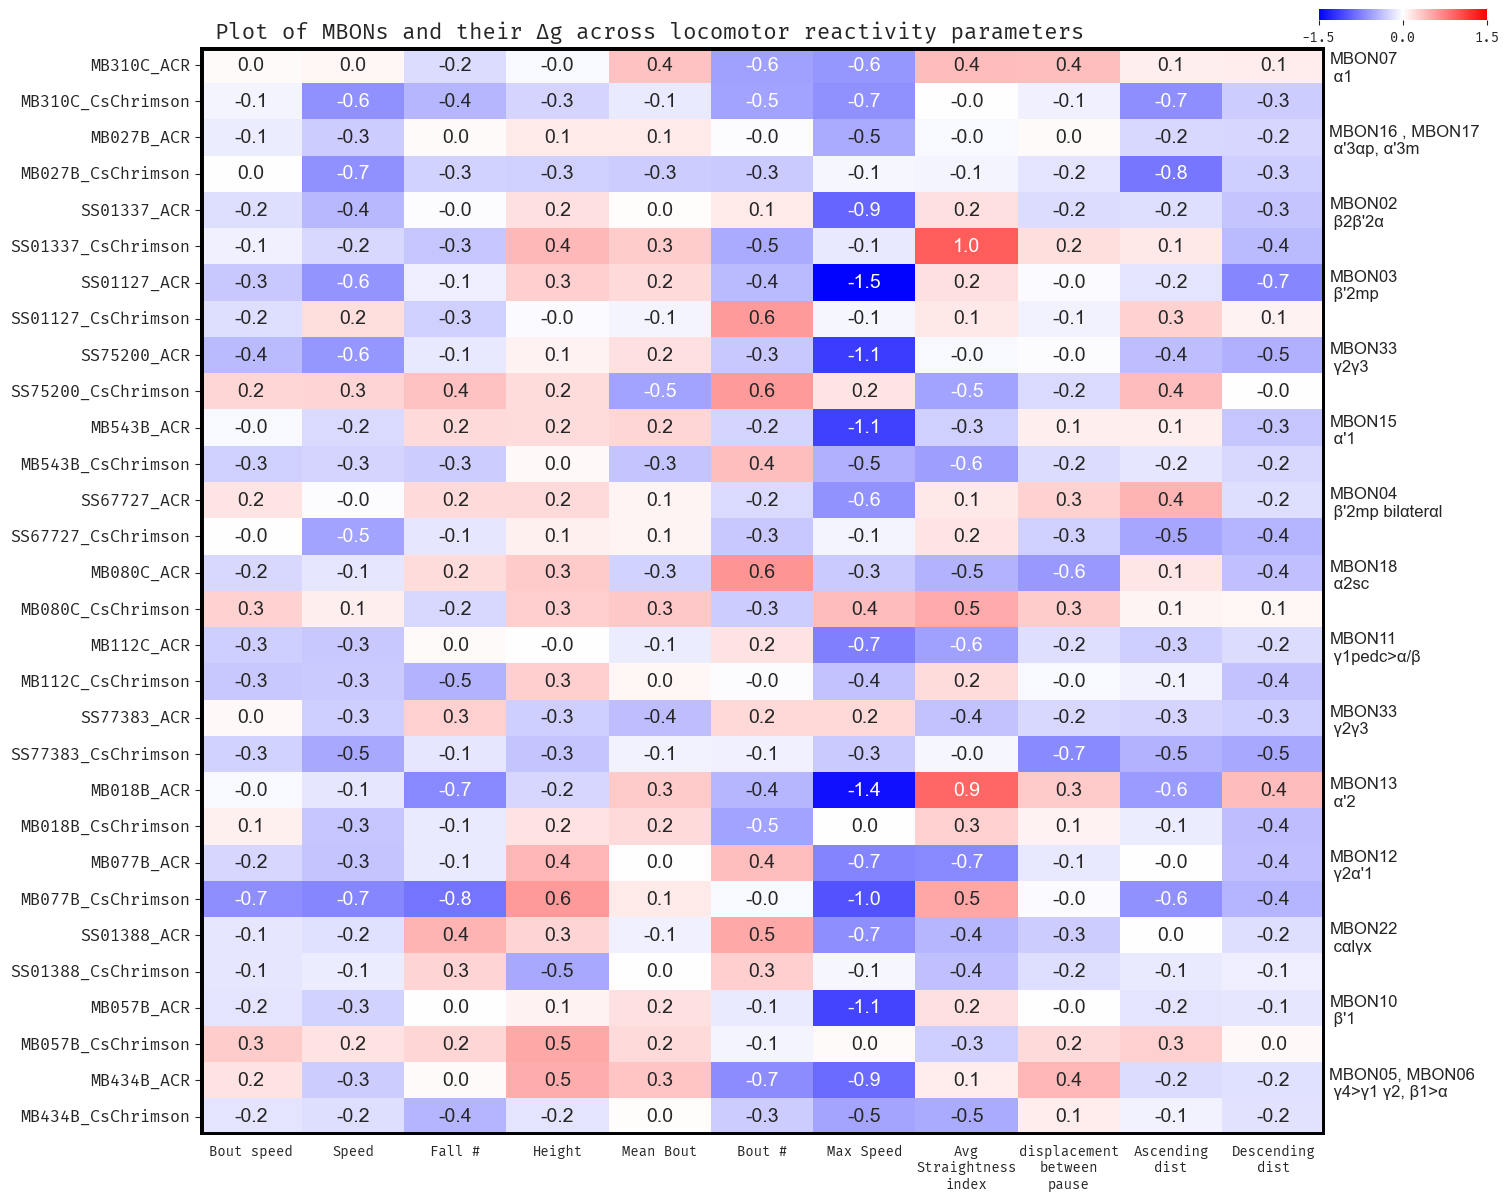

In [16]:
#specific mbon list for ONE

df00 = dfreg_resp.copy()

plt.rcParams["font.family"] = "Fira Mono"

specificmbonlist = dfreg_a['MBON'].tolist()  #change depending on which genotype you want to see

df00 = pd.DataFrame()
for x in specificmbonlist:
    df00 = pd.concat([df00, dfreg_resp[dfreg_resp['MBON'] == x]])

df00.reset_index(drop=True)

df50 = df00.set_index(['responder'])
df50 = df50.drop(['MBON'], axis =1)

fig1, ax3 = plt.subplots(figsize=(15, 12))     

#adding extra axes label
lobloclst = []
mbonloclst = []
df500 = df00.copy()
for n in df00['MBON']:
    lobloclst.append(lobelocation[lobelocation['MBON'] == n]['Lobe_location'].values[0])
    mbonloclst.append(lobelocation[lobelocation['MBON'] == n]['MBON number'].values[0])
df500['Lobe'] = lobloclst
df500['Name'] = mbonloclst

#labelling of MBON number and location but ONLY ifc comparing ACR and CHRIMSON2

newdf500 = pd.DataFrame()
naming = df500['Name'].iloc[::2].to_frame().rename(columns = {"Name": ""})
lobing = df500['Lobe'].iloc[1::2].to_frame().rename(columns = {"Lobe": ""})
newlabel =(naming.values + "\n " + lobing.values).tolist()
newdf500['Merge'] = newlabel

#for individual points, not merging of ACR and Chrimson2 (i.e. different genotypes)

# newdf500 = pd.DataFrame()
# naming = df500['Name'].to_frame().rename(columns = {"Name": ""})
# lobing = df500['Lobe'].to_frame().rename(columns = {"Lobe": ""})
# newlabel =(naming.values + "\n " + lobing.values).tolist()
# newdf500['Merge'] = newlabel

#colorbar
cax = inset_axes(ax3,
                 width="15%",  # width: 40% of parent_bbox width
                 height="1%",  # height: 10% of parent_bbox height
                 loc='lower right',
                 bbox_to_anchor=(0.12, 1.05, 1, 1),
                 bbox_transform=ax3.transAxes,
                 borderpad=-2,
                 )

sns.set_style("whitegrid", {'axes.grid' : False})           
j7 = sns.heatmap(df50, ax = ax3, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='bwr', linewidths=0.0, edgecolor = "none"
                 , clip_on=False, cbar_ax=cax, cbar_kws = dict(orientation = "horizontal", ticks = [-1.5, 0 ,1.5]), annot_kws={"size": 14}) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01 #cbar_kws = dict(orientation = "vertical")
j7.set_ylabel('')
j7.set_yticklabels(j7.get_yticklabels(), va='center', rotation = 0, fontsize = 12)
j7.set_xticklabels(j7.get_xticklabels(), rotation = 0, fontsize = 10)

wrap_labels(j7, 10)

#lines around frame
# from matplotlib.patches import Rectangle

# for i in list(range(0,92,2)):
#     ax3.add_patch(Rectangle((0, i), 9, 2, fill=False, edgecolor='black', lw=2))

# Drawing the overall frame 
j7.axhline(y = 0, color = 'k',  
            linewidth = 5) 
  
j7.axhline(y = 30, color = 'k',   
            linewidth = 5) #72 for max
  
j7.axvline(x = 0, color = 'k', 
            linewidth = 5) 
  
j7.axvline(x = 11, color = 'k', 
            linewidth = 5) 

#secondary axes
j8 = j7.twinx()
j8.set_ylim([0,j7.get_ylim()[0]])
j8.set_yticks(j7.get_yticks())
j8.tick_params(length=0)

#y labels for mbon lobes and naming
labellinglist = newdf500['Merge'].iloc[::-1]
labelledlist = []
for n in labellinglist:
    labelledlist.extend(("", n[0]))  #inserts blank space after every list name
    #labelledlist.extend(n)     #either or
    
#j8.set_yticklabels(newdf500['Merge'].iloc[::-1], fontsize=10)
j8.set_yticklabels(labelledlist, fontsize=12)
j8.spines['top'].set_visible(False)
j8.spines['right'].set_visible(False)
j8.spines['bottom'].set_visible(False)
j8.spines['left'].set_visible(False)


j7.set_title('Plot of MBONs and their Δg across locomotor reactivity parameters', x=0.4, weight='bold', fontsize =16 )

fig1.tight_layout()

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_deltagheatmapwithlobelocations.png", dpi = 1200)

## clustermap

weighted euclidean


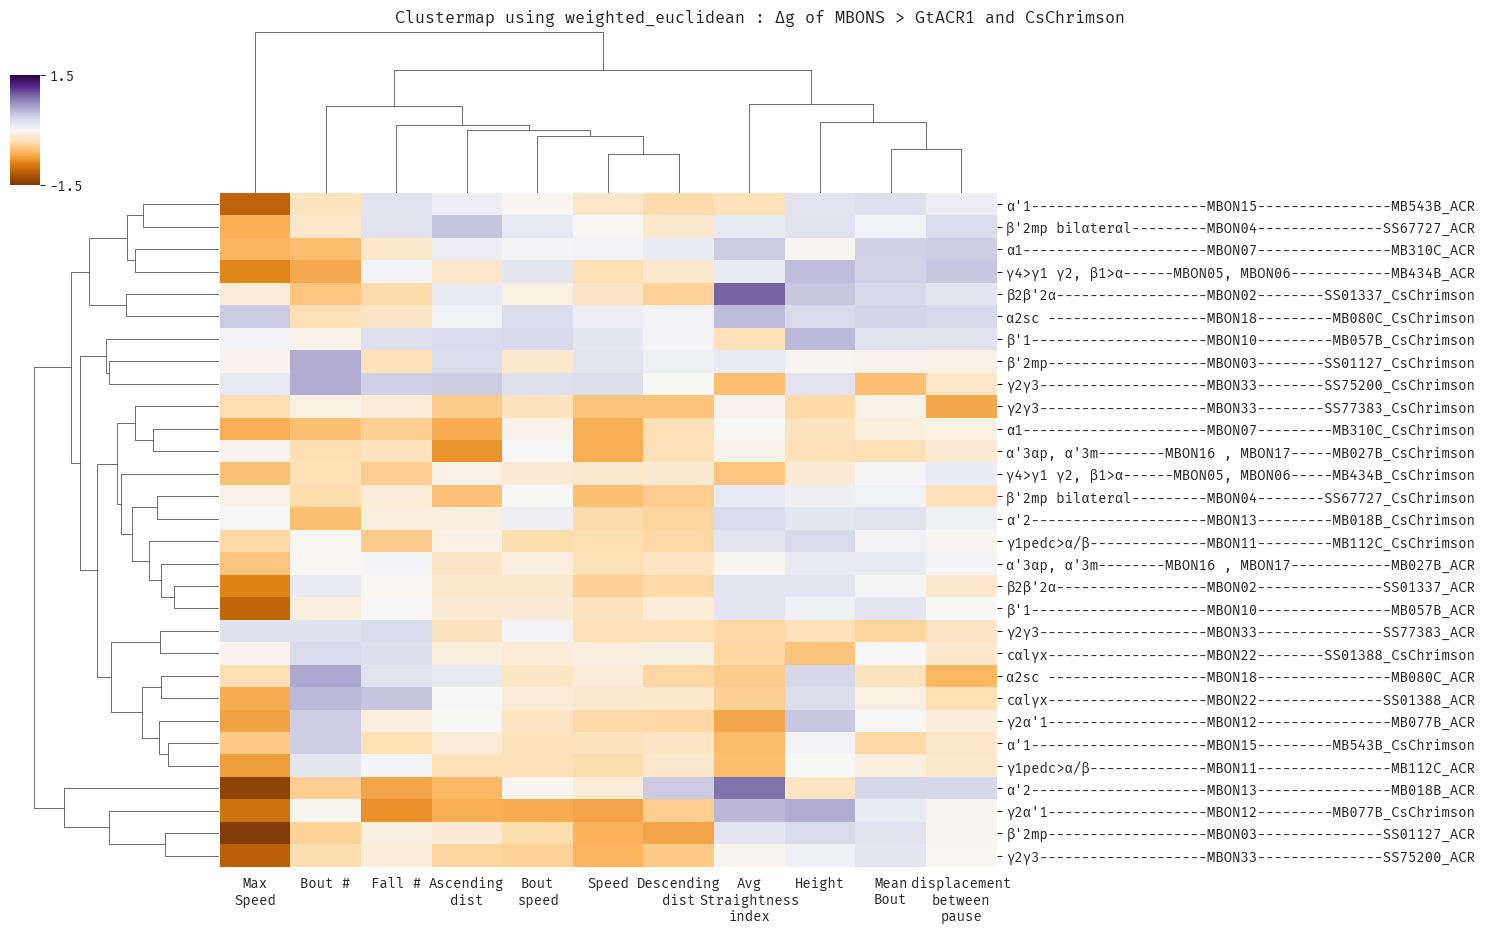

In [20]:
methodlist = ['weighted']
metriclist = ['euclidean']

   
df501 = df500.copy()
df501['totalnaming'] = df501['MBON'] + "; " + df501['responder'] + "; " + df501['Lobe']
df501newset = df501.set_index('totalnaming').iloc[:,0:11]

ylabellist = []
for n, k, z in zip(df501['Name'],df501['Lobe'], df501['responder']):
    ylabels = f"{k:-<18}{n:-^18}{z:->20}"
    ylabellist.append(ylabels)

plt.rcParams["font.family"] = "Fira Mono"

for methodd in methodlist:
    for metricc in metriclist:
        print (methodd + " " + metricc)
        j7 = sns.clustermap(df501newset, cmap= "PuOr", metric = metricc, method = methodd, yticklabels=ylabellist, vmin = -1.5, vmax=1.5,
                            cbar_kws = dict(shrink = 0.2, ticks = [-1.5,1.5]), figsize=(15, 11), cbar_pos=(0, 0.84, .02, .1) ) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01 #vmin = -1.5, vmax=1.5,
        ax = j7.ax_heatmap
        ax.set_ylabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 10)
        wrap_labels(ax, 8)
        j7.fig.suptitle('Clustermap using ' + methodd + "_" + metricc + ' : Δg of MBONS > GtACR1 and CsChrimson' , weight='bold', fontsize =12, y =1.0)

        #plt.rcParams["font.family"] = "Fira Mono"
        #plt.savefig(openPath + "images\\" + date + "_" + responder + "_clustermap_" + methodd + "_" + metricc + "_betweenChrimsonandACR.png", dpi = 1200)

## single responder heatmap

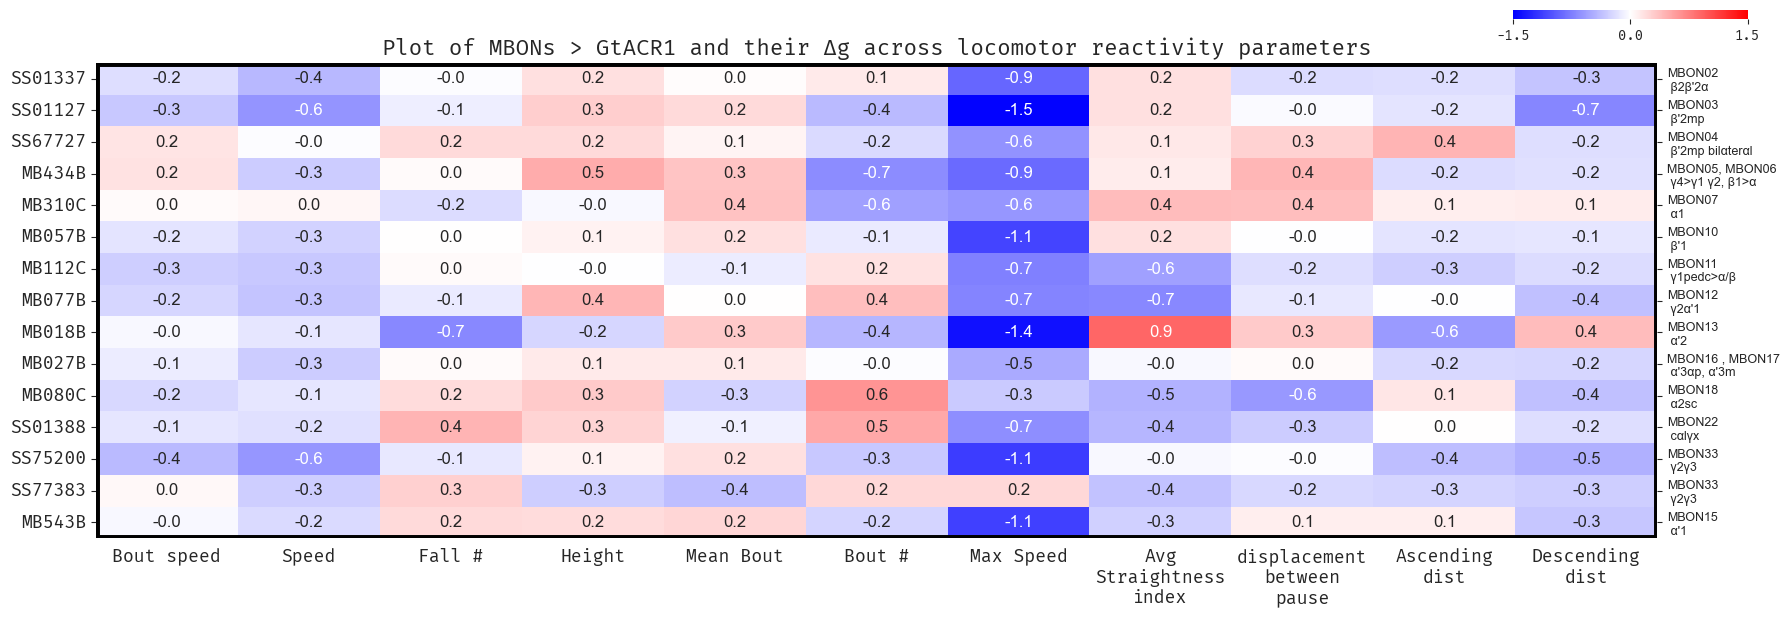

In [21]:
#mini list of only SPECIFIC responder
responder = "ACR"

if responder == 'Chrimson2':
    responderrename = "CsChrimson"
    dfreg_specificresponder = dfreg_c.sort_values(by = "responder", ascending=True).reset_index(drop=True)

if responder == 'ACR':
    responderrename = "GtACR1"
    dfreg_specificresponder = dfreg_a.sort_values(by = "responder", ascending=True).reset_index(drop=True)

plt.rcParams["font.family"] = "Fira Mono"

lstofmbonsiwant = MBONList
df_specificmbon = pd.DataFrame()
for n in lstofmbonsiwant:
    df_specificmbon = pd.concat([df_specificmbon, dfreg_specificresponder[dfreg_specificresponder['MBON'] == n]])
    
df_specificmbon = df_specificmbon.reset_index(drop=True)
df60 = df_specificmbon.set_index(['MBON'])
df60 = df60.drop(['responder'], axis =1)
fig1, ax4 = plt.subplots(figsize=(18, 6))     

#adding extra axes label
lobloclst = []
mbonloclst = []
for n in df_specificmbon['MBON']:
    df600 = df_specificmbon.copy()
    lobloclst.append(lobelocation[lobelocation['MBON'] == n]['Lobe_location'].values[0])
    mbonloclst.append(lobelocation[lobelocation['MBON'] == n]['MBON number'].values[0])
df600['Lobe'] = lobloclst
df600['Name'] = mbonloclst

df600 = df600.sort_values(by = "Name", ascending=True).reset_index(drop=True)
df60extra = df600.iloc[:,:-3].set_index('MBON')   #change depending on parameters

newdf600 = pd.DataFrame()
naming = df600['Name'].to_frame().rename(columns = {"Name": ""})
lobing = df600['Lobe'].to_frame().rename(columns = {"Lobe": ""})
newlabel =(naming.values + "\n " + lobing.values).tolist()
newdf600['Merge'] = newlabel

#colorbar
cax = inset_axes(ax4,
                 width="15%",  # width: 40% of parent_bbox width
                 height="2%",  # height: 10% of parent_bbox height
                 loc='lower right',
                 bbox_to_anchor=(0.04, 1.15, 1, 1),
                 bbox_transform=ax4.transAxes,
                 borderpad=-2,
                 )

sns.set_style("whitegrid", {'axes.grid' : False})    
       
j7 = sns.heatmap(df60extra, ax = ax4, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='bwr', linewidths=0.0, edgecolor = "none"
                 , clip_on=False, cbar_ax=cax, cbar_kws = dict(orientation = "horizontal", ticks = [-1.5,0,1.5]), annot_kws={"size": 12, }) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01 #cbar_kws = dict(orientation = "vertical")
#twilight_shifted also a possible color

j7.set_ylabel('')
j7.set_yticklabels(j7.get_yticklabels(), va='center', rotation = 0, fontsize = 13)
j7.set_xticklabels(j7.get_xticklabels(), rotation = 0, fontsize = 13)

wrap_labels(j7, 10)

# from matplotlib.patches import Rectangle

# for i in list(range(0,46,2)):
#     ax4.add_patch(Rectangle((0, i), 9, 2, fill=False, edgecolor='black', lw=2))

# Drawing the frame 
j7.axhline(y = 0, color = 'k',  
            linewidth = 5) 
  
j7.axhline(y = 15, color = 'k', 
            linewidth = 5) 
  
j7.axvline(x = 0, color = 'k', 
            linewidth = 5) 
  
j7.axvline(x = 11, color = 'k', 
            linewidth = 5) 

#secondary axes
j8 = j7.twinx()
j8.set_ylim([0,j7.get_ylim()[0]])
j8.set_yticks(j7.get_yticks())


#y labels for mbon lobes and naming
labellinglist = newdf600['Merge'].iloc[::-1]
labelledlist = []
for n in labellinglist:
    labelledlist.extend(n)
    #inserts blank space after every list name
j8.set_yticklabels(labelledlist, fontsize=9)
j8.spines['top'].set_visible(False)
j8.spines['right'].set_visible(False)
j8.spines['bottom'].set_visible(False)
j8.spines['left'].set_visible(False)

j7.set_title('Plot of MBONs > ' + responderrename +' and their Δg across locomotor reactivity parameters', x=0.5, weight='bold', fontsize =16)

fig1.tight_layout()

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_deltagheatmapwithlobelocations.png", dpi = 1200)

## single responder clustermap

weighted euclidean


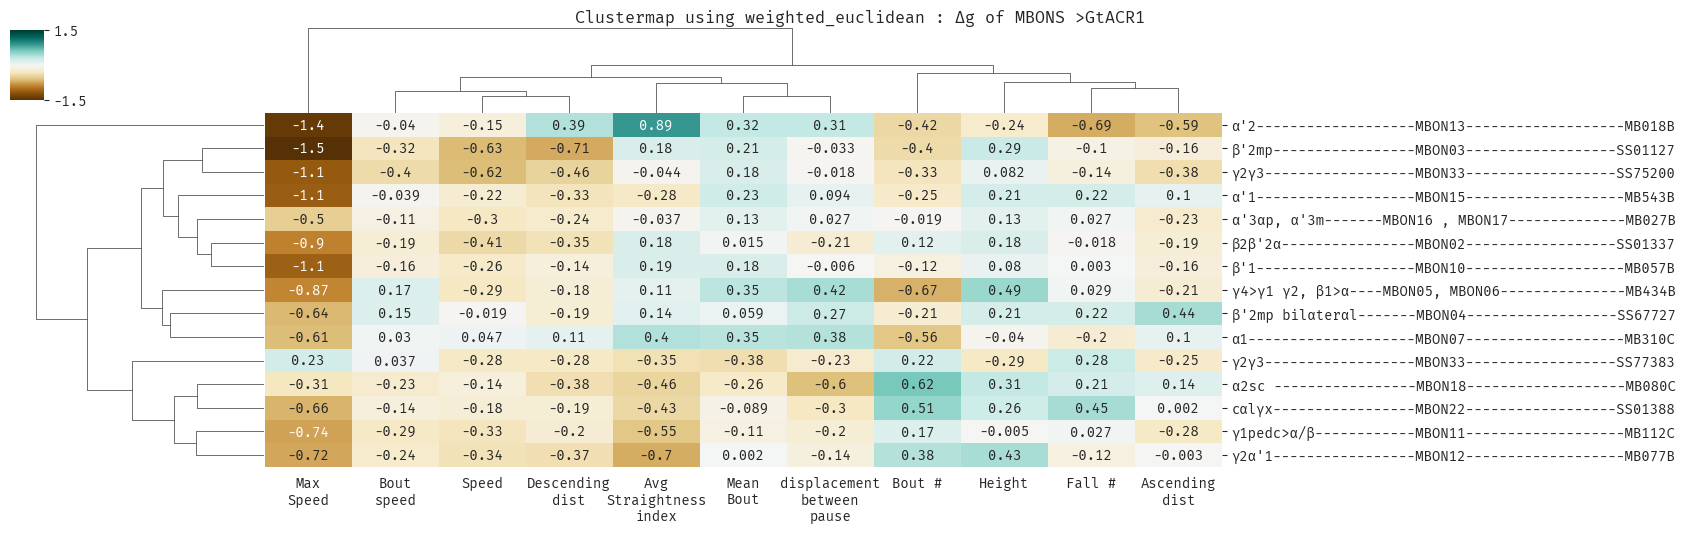

In [24]:
methodlist = ['weighted']
metriclist = ['euclidean']

if responder == 'Chrimson2':
    colormap = 'RdGy'
    
if responder == 'ACR':
    colormap = 'BrBG'
    
df601 = df600.copy()
df601['totalnaming'] = df601['MBON'] + "; " + df601['Name'] + "; " + df601['Lobe']
df601newset = df601.set_index('totalnaming').iloc[:,0:11]

ylabellist = []
for n, k, z in zip(df601['Name'],df601['Lobe'], df601['MBON']):
    ylabels = f"{k:-<18}{n:-^15}{z:->20}"
    ylabellist.append(ylabels)

plt.rcParams["font.family"] = "Fira Mono"

for methodd in methodlist:
    for metricc in metriclist:
        print (methodd + " " + metricc)
        j7 = sns.clustermap(df601newset, cmap=colormap, metric = metricc, method = methodd, yticklabels=ylabellist, vmin = -1.5, vmax=1.5, annot=True,
                            cbar_kws = dict(shrink = 0.15, ticks = [-1.5,1.5]), figsize=(17, 7), cbar_pos=(0, 0.87, .02, .1) ) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01 #vmin = -1.5, vmax=1.5,
        ax = j7.ax_heatmap
        ax.set_ylabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 10)
        wrap_labels(ax, 8)
        j7.fig.suptitle('Clustermap using ' + methodd + "_" + metricc + ' : Δg of MBONS >' + responderrename , weight='bold', fontsize =12, y =1.0)

        #plt.rcParams["font.family"] = "Fira Mono"
        #plt.savefig(openPath + "images\\" + date + "_" + responder + "_clustermap_" + methodd + "_" + metricc + "_betweenChrimsonandACR.png", dpi = 1200)

## differenced heatmap

In [49]:
effectsizediff = pd.DataFrame()
for n in matchingset:
    newt = dfreg_resp[dfreg_resp['MBON'] == n]
    MBONlabel = pd.DataFrame()
    MBONlabel['responder'] = [n]
    newtdiff = newt.iloc[:,:-2].diff().abs().iloc[1:,:].reset_index(drop=True)

    newton = pd.concat([MBONlabel, newtdiff], axis = 1)
    effectsizediff = pd.concat([effectsizediff, newton]).reset_index(drop=True)

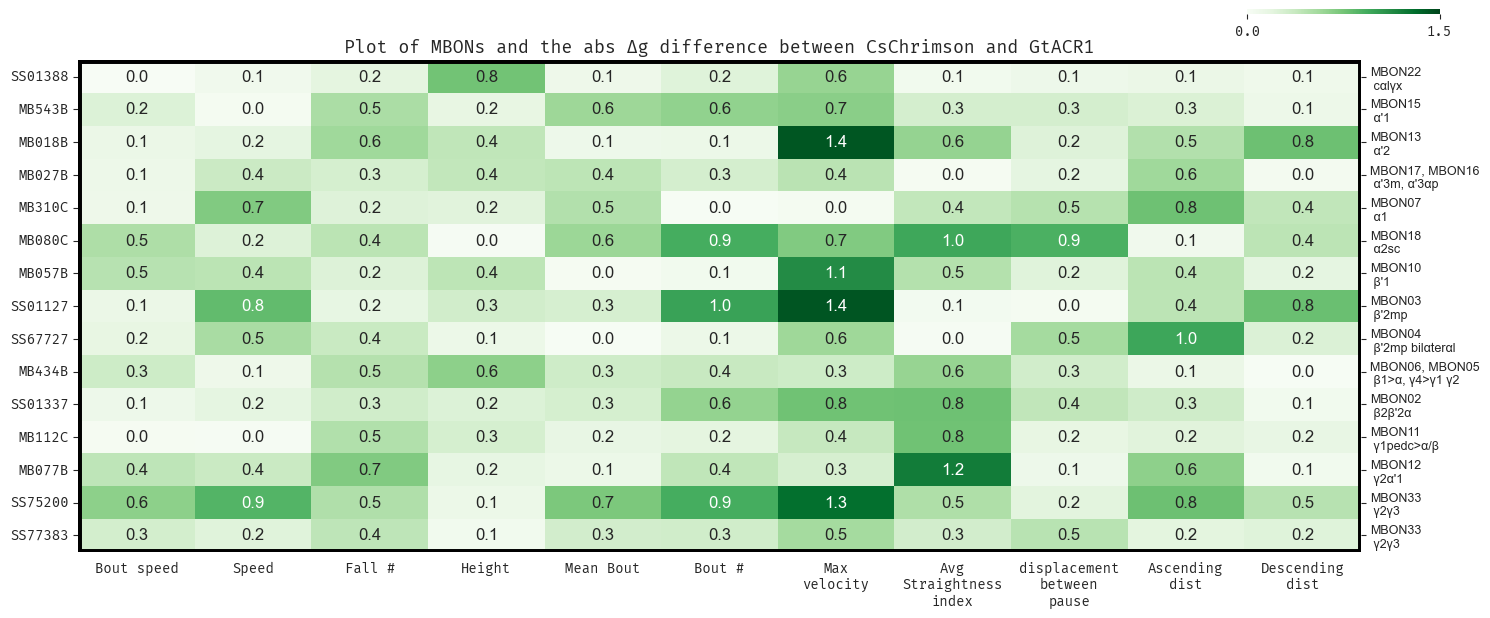

In [72]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

effectsizediff = effectsizediff.sort_values(by = "responder", ascending=True).reset_index(drop=True)
df00 = effectsizediff.copy()
df50 = df00.set_index(['responder'])
fig1, ax3 = plt.subplots(figsize=(15, 6))   

#plt.rcParams["font.family"] = "Fira Mono"
 
#adding extra axes label
lobloclst = []
mbonloclst = []
for n in df00['responder']:
    df700 = df00.copy()
    lobloclst.append(lobelocation[lobelocation['MBON'] == n]['Lobe_location'].values[0])
    mbonloclst.append(lobelocation[lobelocation['MBON'] == n]['MBON number'].values[0])
df700['Lobe'] = lobloclst
df700['Name'] = mbonloclst

#df700 = df700.sort_values(by = "Name", ascending=True).reset_index(drop=True)
df700 = df700.sort_values(by = "Lobe", ascending=True).reset_index(drop=True)
df70extra = df700.iloc[:,0:12].set_index('responder')   #change this number depending on number of parameters

newdf700 = pd.DataFrame()
naming = df700['Name'].to_frame().rename(columns = {"Name": ""})
lobing = df700['Lobe'].to_frame().rename(columns = {"Lobe": ""})
newlabel =(naming.values + "\n " + lobing.values).tolist()
newdf700['Merge'] = newlabel

cax = inset_axes(ax3,
                 width="15%",  # width: 40% of parent_bbox width
                 height="1.0%",  # height: 10% of parent_bbox height
                 loc='lower right',
                 bbox_to_anchor=(0.04, 1.15, 1, 1),
                 bbox_transform=ax3.transAxes,
                 borderpad=-2,
                 )

      
sns.set_style("whitegrid", {'axes.grid' : False})           
j7 = sns.heatmap(df70extra, ax = ax3, annot=True, fmt=".1f", vmin = 0, vmax = 1.5, cmap='Greens', linewidths=0.0, edgecolor = "none"
                 , clip_on=False, cbar_ax=cax, cbar_kws = dict(orientation = "horizontal", ticks = [0, 1.5]), annot_kws={"size": 12}) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01 #cbar_kws = dict(orientation = "vertical")
j7.set_ylabel('')
j7.set_yticklabels(j7.get_yticklabels(), va='center', rotation = 0, fontsize = 10)
j7.set_xticklabels(j7.get_xticklabels(), rotation = 0, fontsize = 10)

wrap_labels(j7, 10)

from matplotlib.patches import Rectangle

# Drawing the frame 
j7.axhline(y = 0, color = 'k',  
            linewidth = 5) 
  
j7.axhline(y = 15, color = 'k', 
            linewidth = 5) 
  
j7.axvline(x = 0, color = 'k', 
            linewidth = 5) 
  
j7.axvline(x = 11, color = 'k', 
            linewidth = 5) 

#secondary axes
j8 = j7.twinx()
j8.set_ylim([0,j7.get_ylim()[0]])
j8.set_yticks(j7.get_yticks())


#y labels for mbon lobes and naming
labellinglist = newdf700['Merge'].iloc[::-1]
labelledlist = []
for n in labellinglist:
    labelledlist.extend(n)
    #inserts blank space after every list name
j8.set_yticklabels(labelledlist, fontsize=9)
j8.spines['top'].set_visible(False)
j8.spines['right'].set_visible(False)
j8.spines['bottom'].set_visible(False)
j8.spines['left'].set_visible(False)

j7.set_title('Plot of MBONs and the abs Δg difference between CsChrimson and GtACR1', x=0.5, weight='bold', fontsize =13 )

fig1.tight_layout()

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_absolutedeltagdiffbetweenChrimsonandACR.png", dpi = 1200)

## differenced clustermap

weighted euclidean


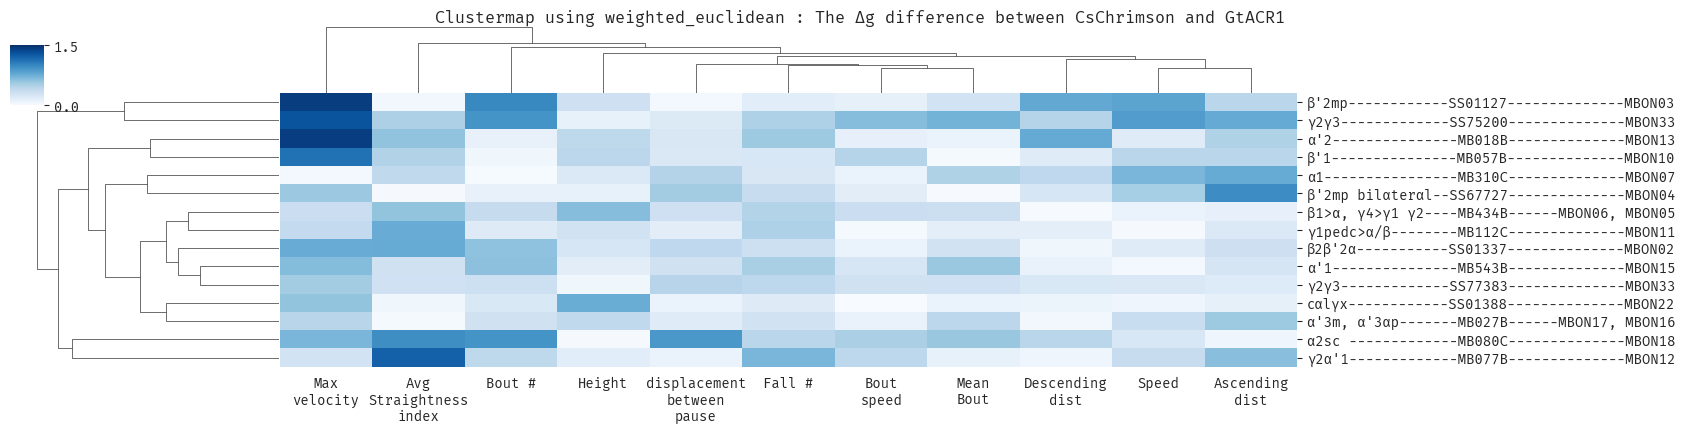

In [57]:
methodlist = ['weighted']
metriclist = ['euclidean']

df800 = df700.copy()
df800['totalnaming'] = df800['responder'] + "; " + df800['Name'] + "; " + df800['Lobe']
df80newset = df800.set_index('totalnaming').iloc[:,1:12]   #change this number depending on parameter amounts

ylabellist = []
for n, k, z in zip(df800['responder'],df800['Lobe'], df800['Name']):
    ylabels = f"{k:-<16}{n:-^10}{z:->18}"
    ylabellist.append(ylabels)
plt.rcParams["font.family"] = "Fira Mono"

for methodd in methodlist:
    for metricc in metriclist:
        print (methodd + " " + metricc)
        j7 = sns.clustermap(df80newset, cmap='Blues', metric = metricc, method = methodd,vmin = 0, vmax=1.5, yticklabels=ylabellist, 
                            cbar_kws = dict(shrink = 0.2, ticks = [0, 1.5]), figsize=(17, 6), cbar_pos=(0, 0.84, .02, .1) ) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01
        ax = j7.ax_heatmap
        ax.set_ylabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 10)
        wrap_labels(ax, 8)
        j7.fig.suptitle('Clustermap using ' + methodd + "_" + metricc + ' : The Δg difference between CsChrimson and GtACR1', weight='bold', fontsize =12, y =1.0)

        #plt.rcParams["font.family"] = "Fira Mono"
        #plt.savefig(openPath + "images\\" + date + "_" + responder + "_clustermap_" + methodd + "_" + metricc + "_betweenChrimsonandACR.png", dpi = 1200)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# lobeloc = specificmbonlist(lobelocation)
dfreglobe =dfreg_ACR.copy()
dfreglobe['Lobe'] = lobelocation['Lobe_location']
dfreglobe['Name'] = lobelocation['MBON number']
df00 = dfreglobe.copy()

df50 = df00.set_index(['Name'])
df50 = df50.drop(['MBON', 'Lobe'], axis =1)
fig1, ax3 = plt.subplots(figsize=(16, 8))     
#colorbar
cax = inset_axes(ax3,
                 width="15%",  # width: 40% of parent_bbox width
                 height="2%",  # height: 10% of parent_bbox height
                 loc='lower right',
                 bbox_to_anchor=(0.1, 1.1, 1, 1),
                 bbox_transform=ax3.transAxes,
                 borderpad=-2,
                 )
sns.set_style("whitegrid", {'axes.grid' : False})           
j7 = sns.heatmap(df50, ax = ax3, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='coolwarm', linewidths=0.5, linecolor='black'
                 , clip_on=False,  cbar_ax=cax, cbar_kws = dict(orientation = "horizontal")) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01
j7.set_ylabel('')
j7.set_yticklabels(j7.get_yticklabels(), va='center', rotation = 0, fontsize = 12)
j7.set_xticklabels(j7.get_xticklabels(), rotation = 0, fontsize = 12)

#secondary axes
j8 = j7.twinx()
j8.set_ylim([0,j7.get_ylim()[0]])
j8.set_yticks(j7.get_yticks())

j8.set_yticklabels(df00['MBON'].iloc[::-1], fontsize=12)
j8.spines['top'].set_visible(False)
j8.spines['right'].set_visible(False)
j8.spines['bottom'].set_visible(False)
j8.spines['left'].set_visible(False)


wrap_labels(j7, 10)
j7.set_title('Plot of MBONs > ' + responder + ' and their Δg across locomotor reactivity parameters for first 20seconds', x=0.4, weight='bold', fontsize =16 )

# #fig1.tight_layout()

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_deltagheatmapwithlobelocations_forfirst10s.png", dpi = 1200)

# PCA Shenanigans

# linear regression, scatter plot, paired plot

## by metrics

In [39]:
dfreg_a = matchingdfs(dfreg_ACR, matchingset)
dfreg_c = matchingdfs(dfreg_Cr2, matchingset)

In [ ]:
import scipy.stats
fig2, ax2 = plt.subplots(nrows = 1, ncols = 9, figsize = (20, 3), sharey = True, layout= 'constrained')
labels = [ ' \n '.join(wrap(l, 12)) for l in dfreg_a.columns[:-2].tolist()]

for c,(n,leg) in enumerate(zip(dfreg_a.columns[:-2].tolist(),8*[False]+[True])):
    spare = pd.DataFrame()
    spare["ACR"] = matchinglobesets(dfreg_a, lobelocation)[n]
    spare['Chrimson2'] = matchinglobesets(dfreg_c, lobelocation)[n]
    spare['NT'] = matchinglobesets(dfreg_c, lobelocation)['Neurotransmitter']
    sns.regplot(x="ACR", y="Chrimson2", data=spare, ci = 95, scatter = False, line_kws={"color": "black", 'lw': 1.5}, ax=ax2[c]) 
    sns.scatterplot(x="ACR", y="Chrimson2", data=spare, hue='NT', s = 3, ax = ax2[c], legend = leg)
    ax2[c].set_xlim([-2,2])
    ax2[c].set_ylim([-2,2])
    ax2[c].set_xlabel(labels[c])
    ax2[c].set_ylabel("")
    
    #pearsons correlation
    pearsonscorrelation = scipy.stats.pearsonr(dfreg_a[n], dfreg_c[n]) #correlation instead of linear regression: trying to find the relationship rather than causation    
    civallow = pearsonscorrelation.confidence_interval(confidence_level=0.95)[0] 
    civalhigh = pearsonscorrelation.confidence_interval(confidence_level=0.95)[1]   
    ax2[c].annotate("Coeff:" + str(round(pearsonscorrelation[0],3)) + "\nCI:" + str(round(civallow,3)) + ", " + str(round(civalhigh,3)), (0.45, 0.8), ha = "left", xycoords = 'axes fraction', fontsize = 8)

fig2.supxlabel("ACR", weight = "bold")
fig2.supylabel("Chrimson2", weight = "bold")
fig2.suptitle("Linear regression with Pearson's coeff", fontsize = 16, weight="bold")

new_labels = ['Glutamate', 'Acetylcholine', 'GABA', 'Acetylcholine, GABA']
legend_handles, _= ax2[c].get_legend_handles_labels()
lgd = fig2.legend(legend_handles, new_labels, 
          bbox_to_anchor=(1,1), ncol = 4, frameon = False)
ax2[c].get_legend().set_visible(False)

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_bidirectionalitycheck.png", dpi = 1200, bbox_inches='tight')

## linear regression grouped by circles

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from matplotlib.patches import Ellipse
# fig3, axthree = plt.subplots(nrows = 1, ncols = 9, figsize = (20, 3), sharey = True, layout= 'constrained')


for c,(n,leg) in enumerate(zip(dfreg_a.columns[:-2].tolist(),8*[False]+[True])):
    fig3, axthree = plt.subplots(figsize = (4, 4))
    
    spare = pd.DataFrame()
    spare["ACR"] = matchinglobesets(dfreg_a, lobelocation)[n]
    spare['Chrimson2'] = matchinglobesets(dfreg_c, lobelocation)[n]
    spare['NT'] = matchinglobesets(dfreg_c, lobelocation)['Neurotransmitter']
    
    #kmeans
    kmeans = SpectralClustering(n_clusters=3)
    clusters = kmeans.fit_predict(spare.iloc[:,0:2])
    cluster = ['k-means_c_' + str(c) for c in clusters]
    X = spare.iloc[:,0:2]
    ogdots = ['#d90429','#f7b267', '#89fc00', '#735751'] #neurotransmitters : red, orange, green, brown
    clusterdots = ["#03045e", '#0077b6', "#00b4d8", "#90e0ef"] #clustering patterns :blue
    
    #neto = sns.scatterplot(x="ACR", y="Chrimson2", data=spare, hue='NT', s = 80, edgecolor = "none", palette = ogdots , legend = True)
    sns.scatterplot(x="ACR", y="Chrimson2", data=X.iloc[:,0:2].assign(cluster = cluster), hue='cluster', palette = clusterdots, legend = False, s = 40, edgecolor = "none")
           
    axthree.set_xlim([-2,2])
    axthree.set_ylim([-2,2])
    axthree.set_xlabel("")
    axthree.set_ylabel("")
    plt.yticks(fontsize=6)
    plt.xticks(fontsize=6)
    

    fig3.supxlabel("ACR", fontsize = 8,  weight = "bold")
    fig3.supylabel("Chrimson2", fontsize = 8, weight = "bold")
    fig3.suptitle(n, fontsize = 12, weight="bold")
    plt.legend(loc=2, prop={'size': 8})
#plt.savefig(openPath + "images\\" + date + "_" + responder + "_bidirectionalitycheck.png", dpi = 1200, bbox_inches='tight')

In [40]:
df_completeresponder = pd.concat([dfreg_a, dfreg_c])
df_lregmbon = df_completeresponder.sort_values(['MBON']).reset_index(drop=True)

In [ ]:
import scipy.stats
fig7, ax7 = plt.subplots(nrows = 5, ncols = 5, figsize = (10, 10), sharey = True, sharex = True, layout= 'constrained')
for name,row,col in zip(dfreg_a['MBON'], 5*list(range(0,5)), 5*[0]+5*[1]+5*[2]+5*[3]+ 5*[4] +5*[5]):
    df_meltedreg = pd.melt(df_lregmbon[(df_lregmbon['MBON'] == name)], id_vars = ['responder', "MBON"])   
    df_a1= df_meltedreg[(df_meltedreg['responder'] == 'Cr2')]
    df_c1=df_meltedreg[(df_meltedreg['responder'] == 'ACR')]
    
    ax7[row][col].scatter(x= df_a1['value'], y = df_c1['value'],
                color='grey',
                edgecolors="r",
                alpha=0.8,
                s=30)
    
    sns.regplot(x= df_a1['value'], y = df_c1['value'],
                scatter=False,
                line_kws={'lw':1}, 
                color="k",
                ax=ax7[row][col],
                truncate=False)

    ax7[row][col].set(xlabel=None)
    ax7[row][col].set(ylabel=None)
    ax7[row][col].set_ylim(-2.1,2.1)  
    ax7[row][col].set_xlim(-2.1,2.1) 
    ax7[row][col].set_title(name, fontsize = 12)

    
    #pearsons correlation
    pearsonscorrelation = scipy.stats.pearsonr(df_a1['value'], df_c1['value']) #correlation instead of linear regression: trying to find the relationship rather than causation    
    civallow = pearsonscorrelation.confidence_interval(confidence_level=0.95)[0] 
    civalhigh = pearsonscorrelation.confidence_interval(confidence_level=0.95)[1]
    ax7[row][col].annotate("Coeff:" + str(round(pearsonscorrelation[0],3)) + "\nCI:" + str(round(civallow,3)) + ", " + str(round(civalhigh,3)), (0.55, 0.8), ha = "left", xycoords = 'axes fraction', fontsize = 9)

    
fig7.supxlabel("ACR", weight = "bold")
fig7.supylabel("Chrimson2", weight = "bold")
fig7.suptitle("Linear regression with Pearson's coeff", fontsize = 16, weight="bold")

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_bidirectionalitycheckMBON.png", dpi = 1200, bbox_inches='tight')

## scatter plot clustering

In [ ]:
if responder == "ACR":
    dfreglobe = dfreg_ACR
    
if responder == "Chrimson2":
    dfreglobe = dfreg_Cr2

dfreglobe['Lobe'] = lobelocation['Lobe_location']
dfreglobe['Name'] = lobelocation['MBON number']
dfreglobe['Neurotransmitter'] = lobelocation['Neurotransmitter']

df00 = dfreglobe.copy()
novt = df00[(df00['MBON']== "VT999036")].index
df50 = df00.drop(novt)
df50 = df50.drop(['MBON', 'Name', 'Lobe'], axis =1)

fig, axes = plt.subplots(figsize=(16,4))

df89 = pd.melt(df50, id_vars = ['Neurotransmitter'], var_name = 'Metrics', value_name = "Δg")
g1 = sns.swarmplot(data=df89, x= 'Metrics', y = 'Δg', hue='Neurotransmitter',dodge = True)
sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))
sns.set_style("darkgrid")
wrap_labels(axes, 10)
g1.set_title('Plot of MBONs > ' + responder + ' and their Δg separated by neurotransmitter types according to locomotor metrics for first ' + secondrule, weight='bold', fontsize =12 )

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_separationbyNTtypes_" + secondrule +".png", dpi = 1200, bbox_inches='tight')

## sns paired plot

In [ ]:
if responder == "ACR":
    dfreglobe = dfreg_ACR
    
if responder == "Chrimson2":
    dfreglobe = dfreg_Cr2

dfreglobe['Lobe'] = lobelocation['Lobe_location']
dfreglobe['Name'] = lobelocation['MBON number']
dfreglobe['Neurotransmitter'] = lobelocation['Neurotransmitter']

df00 = dfreglobe.copy()
novt = df00[(df00['MBON']== "VT999036")].index
df50 = df00.drop(novt)
df50 = df50.drop(['MBON', 'Name', 'Lobe'], axis =1)

t1 = sns.pairplot(data=df50, hue='Neurotransmitter')
t1.fig.suptitle('MBONs > ' + responder, weight='bold', fontsize =16, y = 1.02 )

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_separationbyNTtypes_" + secondrule +".png", dpi = 1200, bbox_inches='tight')

## old clustermap

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

if responder == "ACR":
    dfreglobe = dfreg_ACR
    
if responder == "Chrimson2":
    dfreglobe = dfreg_Cr2
    
dfreglobe['Lobe'] = lobelocation['Lobe_location']
dfreglobe['Name'] = lobelocation['MBON number']
dfreglobe['Neurotransmitter'] = lobelocation['Neurotransmitter']

df00 = dfreglobe.copy()

df50 = df00.set_index(['Lobe'])
df50 = df50.drop(['MBON', 'Name', 'Neurotransmitter'], axis =1)
methodlist = ['average']
metriclist = ['euclidean']

for methodd in methodlist:
    for metricc in metriclist:
        print (methodd + " " + metricc)
        j7 = sns.clustermap(df50, cmap='coolwarm', metric = metricc, method = methodd,vmin = -1.5, vmax=1.5, 
                            cbar_kws = dict(shrink = 0.2, ticks = [-1.5, 1.5]), figsize=(10, 10), cbar_pos=(0, 0.82, .02, .1) ) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01
        ax = j7.ax_heatmap
        ax.set_ylabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 9)
        wrap_labels(ax, 8)
        #j7.fig.suptitle('Clustermap using ' + methodd + "_" + metricc + ' :MBONs > ' + responder + ' and their Δg', weight='bold', fontsize =12, y =1.0)
        
        #plt.savefig(openPath + "images\\" + date + "_" + responder + "_clustermap_" + methodd + "_" + metricc + "_" + secondrule +".png", dpi = 1200)

## heatmap arranged by speed

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

if responder == "ACR":
    dfreglobe = dfreg_ACR
    
if responder == "Chrimson2":
    dfreglobe = dfreg_Cr2
    
lobloclst = []
mbonloclst = []
for n in dfreglobe['MBON']:
    df500 = dfreglobe.copy()
    lobloclst.append(lobelocation[lobelocation['MBON'] == n]['Lobe_location'].values[0])
    mbonloclst.append(lobelocation[lobelocation['MBON'] == n]['MBON number'].values[0])
df500['Lobe'] = lobloclst
df500['Name'] = mbonloclst

df50 = df500.set_index(['Name'])
df50 = df50.drop(['MBON', 'Lobe'], axis =1)
fig1, ax3 = plt.subplots(figsize=(14, 7))     
#colorbar
cax = inset_axes(ax3,
                 width="15%",  # width: 40% of parent_bbox width
                 height="2%",  # height: 10% of parent_bbox height
                 loc='lower right',
                 bbox_to_anchor=(0.1, 1.1, 1, 1),
                 bbox_transform=ax3.transAxes,
                 borderpad=-2,
                 )
sns.set_style("whitegrid", {'axes.grid' : False})           
j7 = sns.heatmap(df50, ax = ax3, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='coolwarm', linewidths=0.5, linecolor='black'
                 , clip_on=False,  cbar_ax=cax, cbar_kws = dict(orientation = "horizontal")) #use_gridspec=False,location="bottom", shrink = 0.25, pad=0.01
j7.set_ylabel('')
j7.set_yticklabels(j7.get_yticklabels(), va='center', rotation = 0, fontsize = 10)
j7.set_xticklabels(j7.get_xticklabels(), rotation = 0, fontsize = 12)

#secondary axes
j8 = j7.twinx()
j8.set_ylim([0,j7.get_ylim()[0]])
j8.set_yticks(j7.get_yticks())

j8.set_yticklabels(df500['Lobe'].iloc[::-1], fontsize=10)
j8.spines['top'].set_visible(False)
j8.spines['right'].set_visible(False)
j8.spines['bottom'].set_visible(False)
j8.spines['left'].set_visible(False)


wrap_labels(j7, 10)
j7.set_title('Plot of MBONs > ' + responder + ' and their Δg across locomotor reactivity parameters' , x=0.4, weight='bold', fontsize =16 )

#fig1.tight_layout()

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_deltagheatmapwithlobelocations.png", dpi = 1200)

## simple heatmap version + delta version

In [ ]:
#simple heatmap
if responder == "ACR":
    df55 = dfreg_ACR
    
if responder == "Chrimson2":
    df55 = dfreg_Cr2
 
df5 = df55.set_index(['MBON'])
fig, ax1 = plt.subplots(figsize=(12, 2))                
g1 = sns.heatmap(df5, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='coolwarm', linewidths=0.5, linecolor='black', clip_on=False)
g1.set_ylabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation = 0, fontsize = 9)
g1.set_xticklabels(g1.get_xticklabels(), rotation = 0, fontsize = 9)
wrap_labels(g1, 10)
ax1.set_title('Plot of MBONs > ' + responder + ' and their Δg across locomotor reactivity parameters')
fig.tight_layout()
#plt.savefig(openPath + "images\\" + date + "_" + responder + "_deltagheatmap_" + secondrule +".png", dpi = 1200)

In [24]:
#delta and delta g heatmap
# 
dfreglist = [dfreg_bspeed.loc[dblist.index], dfreg_speed.loc[dblist.index], dfreg_fall.loc[dblist.index],dfreg_height.loc[dblist.index], dfreg_meanbout.loc[dblist.index], dfreg_bout.loc[dblist.index],dfreg_boutpos.loc[dblist.index], dfreg_maxvelocity.loc[dblist.index],dfreg_straightindex.loc[dblist.index], dfreg_displacementbetweenpause.loc[dblist.index]]
totalregdf = pd.DataFrame()

for n,k in zip(df55.columns[:-1], dfreglist):
    k.columns = pd.MultiIndex.from_product([[n], k.columns.tolist()])
    totalregdf = pd.concat([totalregdf, k], axis =1)


In [ ]:
df0 = totalregdf.copy()
fig, ax2 = plt.subplots(figsize=(18, 6))                

first_row_headers = df0.columns.get_level_values(0)
unique_first_row_headers = first_row_headers.unique()
firstlabels = [ ' \n '.join(wrap(l, 12)) for l in unique_first_row_headers]

second_row_headers = df0.columns.get_level_values(1)
second_headers = [l.replace('delta_', 'Δ') for l in second_row_headers.tolist()]

y3 = sns.heatmap(df0, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='YlGnBu',clip_on=False) # linewidths=0.5, linecolor='black', 
y3.set_ylabel('')
# Calculate the positions for the primary x-tick labels (center of each cell)
tick_positions = [i + 0.5 for i in range(len(second_headers))]

# Set the primary x-axis labels (second row headers)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(second_headers, rotation=0)

#Add the unique first row headers as additional labels
for label in unique_first_row_headers:
    # Find the positions for this label
    positions = [i for i, x in enumerate(first_row_headers) if x == label]

    # Calculate the center position of these columns
    center_position = positions[0]
    newlabel = textwrap.fill(label, 12)
    
    # Place the label with adjusted vertical position
    ax2.text(center_position+0.5, len(second_headers)+0.5, newlabel, ha='left', va='top', rotation=0, weight='bold')
    #wrap_labels(ax2, 10)
    
# Remove x-ax2is label
ax2.set_xlabel("")

ax2.set_title('Plot of MBONs > ' + responder + ' and their Δg across locomotor reactivity parameters')
ax2.vlines(list(range(3,3*12,3)), *ax2.get_xlim(), linewidth=3, color='k')


#fig.tight_layout()

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_cohens d and delta gheatmap_" + secondrule +".png", dpi = 1200)



In [ ]:
lstofmbonsiwant = ['VT999036', 'SS81521', 'SS81353', 'SS75199', 'SS77450', 'MB018B', 'SS01127','SS01337']
totaldf_specificmbon = pd.DataFrame()
ttregdf = totalregdf.reset_index(drop=False)
for n in lstofmbonsiwant:
    totaldf_specificmbon = pd.concat([totaldf_specificmbon, ttregdf[ttregdf['MBON'] == n]])
    
totaldf_specificmbon = totaldf_specificmbon.reset_index(drop=True)

#adding extra axes label
lobloclst = []
mbonloclst = []
for n in totaldf_specificmbon['MBON']:
    df700 = totaldf_specificmbon.copy()
    lobloclst.append(lobelocation[lobelocation['MBON'] == n]['Lobe_location'].values[0])
    mbonloclst.append(lobelocation[lobelocation['MBON'] == n]['MBON number'].values[0])
df700['Lobe'] = lobloclst
df700['Name'] = mbonloclst


df50 = df700.set_index(['Name'])
df0 = df50.drop(['MBON', 'Lobe'], axis =1)

#df0 = totaldf_specificmbon.set_index('MBON')
fig, ax2 = plt.subplots(figsize=(18, 3))                

first_row_headers = df0.columns.get_level_values(0)
unique_first_row_headers = first_row_headers.unique()
firstlabels = [ ' \n '.join(wrap(l, 12)) for l in unique_first_row_headers]

second_row_headers = df0.columns.get_level_values(1)
second_headers = [l.replace('delta_', 'Δ') for l in second_row_headers.tolist()]

y3 = sns.heatmap(df0, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='YlGnBu',clip_on=False) # linewidths=0.5, linecolor='black', 
y3.set_ylabel('')
# Calculate the positions for the primary x-tick labels (center of each cell)
tick_positions = [i + 0.5 for i in range(len(second_headers))]

# Set the primary x-axis labels (second row headers)
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(second_headers, rotation=0)

#Add the unique first row headers as additional labels
for label in unique_first_row_headers:
    # Find the positions for this label
    positions = [i for i, x in enumerate(first_row_headers) if x == label]

    # Calculate the center position of these columns
    center_position = positions[0]
    
    newlabel = textwrap.fill(label, 12)
    
    # Place the label with adjusted vertical position
    ax2.text(center_position+0.5, len(second_headers)-17.5, newlabel, ha='left', va='top', rotation=0, weight='bold')
    #wrap_labels(ax2, 10)

#secondary axes
j8 = ax2.twinx()
j8.set_ylim([0,ax2.get_ylim()[0]])
j8.set_yticks(ax2.get_yticks())

j8.set_yticklabels(df700['Lobe'].iloc[::-1], fontsize=10)
j8.spines['top'].set_visible(False)
j8.spines['right'].set_visible(False)
j8.spines['bottom'].set_visible(False)
j8.spines['left'].set_visible(False)


# Remove x-ax2is label
ax2.set_xlabel("")

ax2.set_title('Plot of MBONs > ' + responder + ' and their Δg across locomotor reactivity parameters')
ax2.vlines(list(range(3,3*12,3)), *ax2.get_xlim(), linewidth=3, color='k')


#fig.tight_layout()

#plt.savefig(openPath + "images\\" + date + "_" + responder + "_cohens d and delta gheatmap_" + secondrule +".png", dpi = 1200)

